In [218]:
import sys
import time
import bibtexparser
import itertools
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup
from tabulate import tabulate

In [2]:
import bibtexparser
bibtex_file = open('gap-publishednicer.bib.txt', encoding='utf-8')
bib_data = bibtexparser.load(bibtex_file)

In [106]:
bib = bib_data.entries

In [163]:
bib_df = pd.DataFrame.from_dict(bib)
review_df = pd.read_csv('no_citation_text.csv', dtype='str')
corpus_df = pd.read_csv('gap_citations_corpus.csv', dtype='str')

In [164]:
bib_df.columns

Index(['printedkey', 'doi', 'url', 'mrreviewer', 'mrnumber', 'mrclass', 'issn',
       'fjournal', 'pages', 'year', 'volume', 'journal', 'title', 'author',
       'ENTRYTYPE', 'ID', 'number', 'school', 'booktitle', 'isbn', 'note',
       'publisher', 'day', 'keywords', 'month', 'series', 'annote', 'type',
       'address', 'institution', 'howpublished', 'editor', 'bookeditor',
       'edition', 'key', 'organization'],
      dtype='object')

# Larger dataset from Bibliography

We only need some of these columns, hence we `drop` the rest.

In [169]:
bib_df.drop(bib_df.columns[[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]], axis = 1, inplace = True)

In [170]:
bib_df.columns

Index(['mrnumber', 'year', 'journal', 'author', 'ENTRYTYPE'], dtype='object')

In [172]:
bib_df = bib_df[['mrnumber', 'author', 'journal', 'year', 'ENTRYTYPE']]

Then we change the `mrnumber` coulmn name to `MRN` so we cane later merge this dataframe with the other one.

In [173]:
bib_df.columns = ['MRN', 'author', 'journal', 'year', 'ENTRYTYPE']

In [178]:
bib_df.head(7)

,MRN,author,journal,year,ENTRYTYPE
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article
2,NaN,"Abdeljaouad, I.",RAIRO-INF THEOR APPL,1999,article
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article
5,1864795,"Abdollahi, A.",Houston J. Math.,2001,article
6,2371966,"Abdollahi, A.",J. Algebra,2007,article


Data types and count of non-null values for each columns.

In [180]:
bib_df.info(show_counts  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MRN        3159 non-null   object
 1   author     3367 non-null   object
 2   journal    3047 non-null   object
 3   year       3367 non-null   object
 4   ENTRYTYPE  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


Looking at the `MRN` columns, some cells are empty - `NaN`

In [177]:
bib_df.iloc[3274]

MRN                    NaN
author          Wegner, A.
journal                NaN
year                  1989
ENTRYTYPE    mastersthesis
Name: 3274, dtype: object

In [122]:
bib_df.describe()

,ID,author,journal,year,ENTRYTYPE
count,3367,3367,3047,3367,3367
unique,3366,2511,384,43,10
top,MR3656296,"Sambale, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


### We will look at the `year` coulumn. There are several anomalies and we need just 4 digits in each cell.

In [181]:
bib_df.sort_values('year', ascending=False)

,MRN,author,journal,year,ENTRYTYPE
3165,3973299,"Then, H.",NaN,[2019] \copyright 2019,incollection
1546,3898507,"Greer, M.",NaN,[2019] \copyright 2019,incollection
3133,3898514,"Stuhl, I. and Vojtěchovský, P.",NaN,[2019] \copyright 2019,incollection
3147,3782458,"Swinarski, D.",NaN,[2018] \copyright 2018,incollection
1981,4167659,"Kaushik, R. and Yadav, M. K.",J. Algebra,2021,article
...,...,...,...,...,...
3274,NaN,"Wegner, A.",NaN,1989,mastersthesis
2689,NaN,"Niemeyer, A.",NaN,1988,mastersthesis
2673,NaN,"Nickel, W.",NaN,1988,mastersthesis
3018,NaN,"Schönert, M.",NaN,1987,mastersthesis


We will use `.str` and a regular expresion `(r'^(\d{4})'` which first converts all year cells to strings then takes the first 4 digits from each. We then replace the old values with the filtered ones.

In [184]:
bib_df['year'] = bib_df['year'].str.extract(r'^(\d{4})', expand=False)

In [185]:
bib_df['year'].value_counts()

2017    188
2013    175
2018    168
2020    166
2019    165
2010    163
2015    162
2016    158
2014    154
2011    152
2007    142
2012    142
2008    132
2004    131
2005    128
2009    124
2006    118
2001    107
2003    101
1999     84
2002     84
2000     78
1997     76
1998     58
1995     56
2021     39
1996     34
1994     28
1993     25
1992     13
1991      5
1987      2
1988      2
1989      2
1990      1
Name: year, dtype: int64

We inspect the result and no more anomalies are visible. Data type is integer which is also fine.

In [186]:
bib_df['year'].describe()

count     3363
unique      35
top       2017
freq       188
Name: year, dtype: object

Barchart dislaying number of GAP citations per year.

<AxesSubplot:>

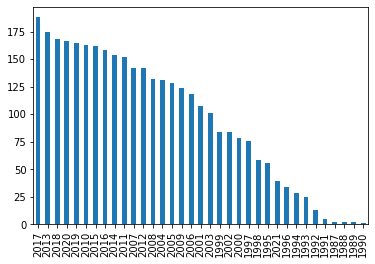

In [152]:
bib_df['year'].value_counts().plot(kind="bar")

Top 20 journals citing GAP.

In [253]:
top_journals = bib_df['journal'].value_counts()

In [254]:
top_20 = pd.DataFrame(top_journals.head(20))
top_20.reset_index()

,index,journal
0,J. Algebra,387
1,Comm. Algebra,207
2,J. Symbolic Comput.,104
3,Discrete Math.,88
4,J. Algebra Appl.,85
5,J. Group Theory,67
6,J. Pure Appl. Algebra,64
7,Internat. J. Algebra Comput.,64
8,Des. Codes Cryptogr.,59
9,LMS J. Comput. Math.,47


In [258]:
headers = ['Journal name', 'GAP Citations count']
print(tabulate(top_20, headers = headers, tablefmt = 'pretty'))

+------------------------------+---------------------+
|         Journal name         | GAP Citations count |
+------------------------------+---------------------+
|          J. Algebra          |         387         |
|        Comm. Algebra         |         207         |
|     J. Symbolic Comput.      |         104         |
|        Discrete Math.        |         88          |
|       J. Algebra Appl.       |         85          |
|       J. Group Theory        |         67          |
|    J. Pure Appl. Algebra     |         64          |
| Internat. J. Algebra Comput. |         64          |
|     Des. Codes Cryptogr.     |         59          |
|     LMS J. Comput. Math.     |         47          |
|     Arch. Math. (Basel)      |         44          |
|     European J. Combin.      |         42          |
|      Experiment. Math.       |         42          |
|         Math. Comp.          |         37          |
|       Algebra Colloq.        |         35          |
|     Elec

In [83]:
bib_df['ENTRYTYPE'].describe()

count        3367
unique         10
top       article
freq         2976
Name: ENTRYTYPE, dtype: object

In [120]:
bib_df['ENTRYTYPE'].value_counts()

article          2976
incollection      204
inproceedings      54
phdthesis          47
mastersthesis      46
book               31
misc                5
techreport          2
inbook              1
manual              1
Name: ENTRYTYPE, dtype: int64

##### The most frequent type of work citing GAP is article.

<AxesSubplot:>

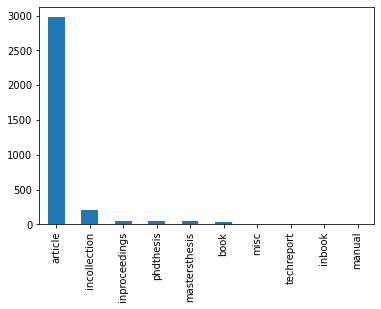

In [84]:
bib_df['ENTRYTYPE'].value_counts().plot(kind="bar") # base from leccture 8 CS2006

In [154]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
interact(f, x=['apples','oranges']);

#  Corpus and Review

To do
+ check Citations strings lenghts to isolate too short ones
+ version
+ website
+ remaining HTML characters

In [20]:
corpus_df

,MR,Citation
0,MR4056124,"GAP – Groups, algorithms, programming - a syst..."
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:..."
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro..."
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ..."
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg..."
...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais..."
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi..."
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h..."
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g..."


In [49]:
print(corpus_df[corpus_df['MR'].str.contains("MR3942387")])

          MR                                           Citation
1  MR3942387  Delgado, M., García-Sánchez, P.A., Morais, J.:...
2  MR3942387  The GAP Group: GAP—groups, algorithms, and pro...


In [50]:
exa = corpus_df[corpus_df['MR'].str.contains("MR3942387")]

In [57]:
exa.iloc[0]['Citation']

'Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 \nMR3493240'

In [58]:
exa.iloc[1]['Citation']

'The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017'

In [59]:
exa1 = corpus_df[corpus_df['MR'].str.contains("MR2822510")]

In [60]:
exa1

,MR,Citation
3523,MR2822510,http://www.gap-system.org.


In [268]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
def get_citation(mrno):
 r = corpus_df[corpus_df['MR'] == mrno]
 return [r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']]

In [265]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
unknown_ver = []
def get_version(s):
    match = re.search("[\s|(]V\w*\s*([\d.]+)", s, re.IGNORECASE)
    if match != None:
        return match.group(1)
    else:
        print('No match:', s)
        unknown_ver.append(s)

In [282]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
def fill_versions(series):
    mrno = series['MR']
    citation = series['Citation']
    match = re.search("[\s|(]V[a-z|\.]*\s*([\d\.]+[\d])", citation, re.IGNO
    if match != None:
        if re.search("package", citation, re.IGNORECASE) == None:
            return match.group(1)
        else:
            print('??? PKG ???:', mrno, citation)
    else:
        print('*** No match:', mrno, citation)
        return None 

SyntaxError: invalid syntax (<ipython-input-282-78ef710edf6a>, line 7)

In [266]:
corpus_df['Version'] = corpus_df['Citation'].map(get_version)

No match: GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
No match: Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
No match: The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
No match: M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [10].
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [8].
No match: Gamble, G., Nickel, W., O'Brien, E.A.: ANU p-Quotient–p-Quotient and p-Group Generation Algorithms (2006). An accepted GAP 4 package, available also in MAGMA
No match: M. Schönert et al, GAP: groups, algorithm and programming, © 1992 by Lehrstuhl 

No match: M. Schönert et al., GAP: Groups, Algorithms and Programming, Aachen, April 1992.
No match: M. Schönert, et al., GAP: Groups, Algorithms and Programming, Aachen, April 1992.
No match: Alp, M., 1997. GAP, Crossed Modules, $\roman{Cat}^{1}$-groups: Applications of Computational Group Theory, Ph.D. Thesis, University of Wales, Bangor. Available from http://www.informatics.bangor.ac.uk/public/math/research/ftp/theses/alp.ps. gz. 
MR1675053
No match: Schönert, M. et al., 1997. GAP-Groups, Algorithms, and Programming, 6th edn. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany.
No match: Delgado, M., Linton, S., Morais, J.E., 2005. GAP package Automata. http://cmup.fc.up.pt/cmup/mdelgado/automata/.
No match: Roney-Dougal, C., Hulpke, A. GAP Data Library "Primitive Permutation Groups." Available at http://www.gap-system.org/Datalib/prim.html.
No match: G. Pfeiffer, Character tables of Weyl groups in GAP, Bayreuth. Math. Schr. 47 (1994), 165–222.

No match: M. Delgado and J. Morais, `SgpViz, a GAP [27] package to visualize finite semigroups (http://www.gap-system.org/Packages/sgpviz.html)'.
No match: Martin Schönert et al., ${\rm GAP}$ - Groups, Algorithms, and Programming, Lehrstuhl ${\rm D}$ für Mathematik, RWTH-Aachen, Germany, fifth edition, 1995
No match: Schönert, M. et al.: GAP—Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH-Aachen, Germany, fifth edition, 1995.
No match: M. Delgado, P.A. Garcia-Sánchez, J. Morais. NumericalSgps - a GAP package, 0.95, 2006, http://www.gap-system.org/ Packages/numericalsgps.
No match: Delgado, M., García-Sánchez, P.A., Morais, J.: NumericalSgps-a GAP package, 0.95 (2006). http://www.gap-system.org/Packages/numericalsgps
No match: The GAP Group, GAP - Groups, Algorithms, and Programming-Version 4-4-10 (2007) (http://www.gap-system.org).
No match: M. Delgado, P. A. (Garcia-Sánchez, J. Morais, NumericalSgps - a GAP package, 0.95 (2006), (http://www.gap-system.org/Packages

No match: M. Schönert. Analyzing Rubik's cube with GAP. Examples under www.gap-system.org, 1993.
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [21].
No match: B. Eick, W. Nickel, Polycyclic—computing with polycyclic groups, 2005. A refereed GAP 4 package, see [20].
No match: B. Eick and E. O'Brien, AutPGrp—Computing the automorphism group of a $p$-group, 2005. A refereed GAP 4 package, see [20]. 
MR2050106
No match: B. Eick, W. Nickel, Polycyclic - Computing with polycyclic groups, 2005, a refereed GAP 4 package, see [28].
No match: B. Eick, E. O'Brien, AutPGrp - Computing the automorphism group of a $p$-group, 2005, a refereed GAP 4 package, see [28]. 
MR2050106
No match: M. Horn, An extension of the Small Groups library, 2013, a GAP 4 package, see [28].
No match: M. Horn, B. Eick, GroupExt - Constructing finite groups, 2013, a GAP 4 package, see [28].
No match: M. Neunhoeffer, F. Noeske, Genss - Generic Schreier—Sims, 2012, A GAP 4 package, see [28].
No match: C. Sieve

No match: I. M. Araújo, et. al., "GAP Reference Manual," The GAP Group, available at http://www.gap-system.org
No match: J. Cramwinckel, et. al., "GUAVA A GAP 4 Package for Computing with Error-Correcting Codes," available at http://cadigweb.ew.usna.edu/$\sim$wdj/gap/GUAVA/
No match: I.M. Araújo, et al., GAP Reference Manual, The GAP Group, http://www.gap-system.org.
No match: J. Cramwinckel, et al., GUAVA A GAP 4 Package for Computing with Error-Correcting Codes, http://cadigweb.ew.usna.edu/$\sim$wdj/gap/GUAVA/.
No match: I.M. Araújo, and 50 co-authors, GAP Reference Manual, The GAP Group, http://www.gap-system.org.
No match: J. Cramwinckel, E. Roijackers, R. Baart, E. Minkes, L. Ruscio, C. Tjhai, D. Joyner, GUAVA A GAP4 package for computing with error-correcting codes, http://cadigweb.ew.usna.edu/$\sim$wdj/gap/GUAVA/.
No match: I. M. Araújo, et al., GAP reference manual, The GAP Group, http://www.gap-system.org
No match: I. M. Araújo, et al., GAP Reference Manual, The GAP Group, htt

No match: M. Schönert et al., GAP—Groups, Algorithms, and Programming, Lehrstuhl D fur Mathematik, RWTH, Aachen, 1994.
No match: GAP-Groups, Algorithms and Programming (http://www.gap-system.org).
No match: GAP—Groups, Algorithms and Programming (http://www.gap-system.org).
No match: A. Bächle, L. Margolis, HeLP–A GAP-package for torsion units in integral group rings, preprint, arXiv:1507.08174, 2015, 6 pp. 
cf. MR3820369
No match: Bächle, A., Margolis, L., 2018. HeLP: a GAP package for torsion units in integral group rings. J. Softw. Algebra Geom. 8, 1–9. 
MR3820369
No match: A. Bächle, L. Margolis, HeLP – a GAP-package for torsion units in integral group rings, preprint, arXiv:1507.08174v3, 2015–2017, 6 pages. 
cf. MR3820369
No match: Martin Schönert et al. GAP—Groups, Algorithms, and Programming. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth edition.
No match: The GAP Group, GAP-4.3—Groups, Algorithms and Programming, Aachen, St. An

No match: Martin Schönert et al., GAP - Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth ed., 1995, Home page: http://www.gap-system.org.
No match: Phillips, J.D., Vojtěchovský, P., 2004. GAP library for wreath products associated with linear identities. Available electronically at http://www.math.du.edu/$\sim$petr in section research| computing.
No match: M. Schönert et al., GAP 3.1 manual, March 1992, Lehrstuhl D für Mathematik, RWTH Aachen.
No match: The GAP Group, GAP - Groups, Algorithms, Programming - a System for Computational Discrete Algebra (http://www.gap-system.org/). Greene, C. Weight enumeration and the geometry of linear codes. Studies in Appl. Math. 55 (1976), no. 2, 119–128. 
MR0447020
No match: A. Hanaki, Elementary functions for association schemes on GAP (2012), http://kissme.shinshu-u.ac.jp/as/gap/.
No match: M. Schönert et al., GAP - Groups, Algorithms and Programming, Lehrstuhl D

No match: M. Schönert et al., "Gap: Groups, Algorithms and Programming, 3.4.3," RWTH Aachen, 1996.
No match: M. Delgado, P. A. García-Sánchez and J. Morais, "numericalsgps": a gap package on numerical semigroups; available at http://www.gap-system.org/Packages/numericalsgps.html.
No match: S. Kohl, A bound on the order of the outer automorphism group of a finite simple group of given order (2003), http://www.gap-system.org/DevelopersPages/StefanKohl/preprints/outbound.pdf. 
cf. MR1808358
No match: I. Abdeljaouad, Calculs d'invariants primitifs de groupes finis, Theor. Inform. Appl. 33(1) (1999) 59–77, http://www-gap.mcs.st-and.ac.uk/Gap3/Contrib3/contrib.html. 
MR1705856
No match: M. Schönert et. al., Gap: groups, algorithms and programming, 3.4.3, RWTH Aachen, 1996.
No match: A simple multiple particle tracker with gap closing. https://www.mathworks.com/matlabcentral/fileexchange/34040-simple-tracker (Accessed 10.01.16).
No match: M. Delgado, P.A. García-Sánchez and J. Morais, "numeri

In [269]:
get_citation('MR3303600')

["A. Distler and J. D. Mitchell, `Smallsemi—a GAP package, version 0.6.2', 2010, http://www.gap-system.org/Packages/smallsemi.html.",
 '0.6.2']

In [280]:
corpus_df['Version'].value_counts()

4.4        378
4.4.12     251
4.3        192
4.4.10     121
4.2        112
          ... 
0.14.        1
1.5.4.       1
10.1.        1
3.4.0        1
4.10.1.      1
Name: Version, Length: 249, dtype: int64

df = pd.DataFrame(lis_dic)
df = df[df.ID.isin(targets)]
df_filtered = df[df.mrnumber.isin(mrs)]

# Merging the two dataframes with the equivalent of SQL `join`

In [121]:
merged_df = pd.merge(bib_df,corpus_df,on='ID',how='outer',indicator=True)

KeyError: 'ID'